# Лабораторная работа 1. Классические методы построения рекомендаций.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/shashist/recsys-course/blob/main/homeworks/hw_01/rs_hw01.ipynb)

В лабораторной вам нужно будет реализовать несколько метрик, применить  популярные модели и оценить влияние гиперпараметров на качество рекомендаций.

### Формат сдачи задания
Лаботаторная сдается в виде ipynb-файла. Каждое выполененное задание должно сопровожаться текстом с выводами. Добавьте визуализации результатов, например, в заданиях на сравнение качества при разных гиперпараметрах. Постарайтесь делать код лаконичным и понятным для проверяющих.

Фиксируйте random seed для воспроизводимости результатов.


### Оценивание
За лабораторную можно получить максимум 5 баллов. Предполагается, что вычислительных ресурсов google colab хватит для успешного выполнения работы.

### Общая информация о задаче
В лабораторной работе будет использоваться классический датасет [MovieLens 1M](https://paperswithcode.com/sota/collaborative-filtering-on-movielens-1m), содержащий оценки фильмов пользователями и признаки пользователей и фильмов.

Для всех заданий, связанных с генерацией рекомендаций, $K=20$, т.е. вам необходимо подготовить по 20 рекомендаций для каждого пользователя.

Так как датасет из области кино, и нам дана информация об оценках, необходимо выполнять фильтрацию просмотренных айтемов при генерации рекомендаций.

Мы будем разделять датасет на 2 части, train и validation, так как целью заданий является наглядная оценка влияния ключевых гиперпараметров (число соседей/латентных факторов) на качество. Если вы будете подбирать другие гиперпараметры моделей (коэффициенты регуляризации в als, коэффициенты K1 и B в bm25), отделите самостоятельно часть train для подбора параметров, а итоговое качество оценивайте после подбора параметров на validation. Подбор гиперпараметров можно реализовать, например, с помощью optuna.

Используйте последнюю версию библиотеки implicit. Пожалуйста, посмотрите [документацию](https://benfred.github.io/implicit/api/models/recommender_base.html) и примеры использования на [github](https://github.com/benfred/implicit), чтобы лучше разобраться с форматом входных данных.

Вопросы по заданию можно писать в чат курса. Ссылка на форму для отправки решений будет дана в чате.

In [14]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
K = 20
SEED = 123
np.random.seed(SEED)

## Знакомство с данными

    


## Задание 1

**(0.5 балла) Задание 1.** Знакомство с данными.
Проанализируйте, насколько активно пользователи оставляют оценки, насколько активно фильмы получают оценки, какие оценки преобладают, как меняется количество оценок во времени. Опишите свои результаты.

In [3]:
!pip install rs-datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.7/413.7 kB 22.8 MB/s eta 0:00:00


In [4]:
from rs_datasets import MovieLens

In [5]:
data = MovieLens("1m")
data.info()

INFO:rs_datasets:Downloading ml-1m from grouplens...
5.93MB [00:01, 4.56MB/s]                            


ratings


,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968



users


,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117



items


,item_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [6]:
def get_log_info(log, user_id='user_id', item_id='item_id'):
    print('Длина лога = {},\nколичество пользователей = {},\nколичество объектов = {}'
          .format(log.shape[0], log[user_id].nunique(), log[item_id].nunique()))

In [7]:
reviews = data.ratings
reviews.rename(columns={"rating": "relevance"}, inplace=True)
reviews['timestamp'] = pd.to_datetime(reviews['timestamp'], unit='s')
reviews.head(1)

,user_id,item_id,relevance,timestamp
0,1,1193,5,2000-12-31 22:12:40


In [10]:
get_log_info(reviews)

Длина лога = 1000209,
количество пользователей = 6040,
количество объектов = 3706


Text(0, 0.5, 'Частота')

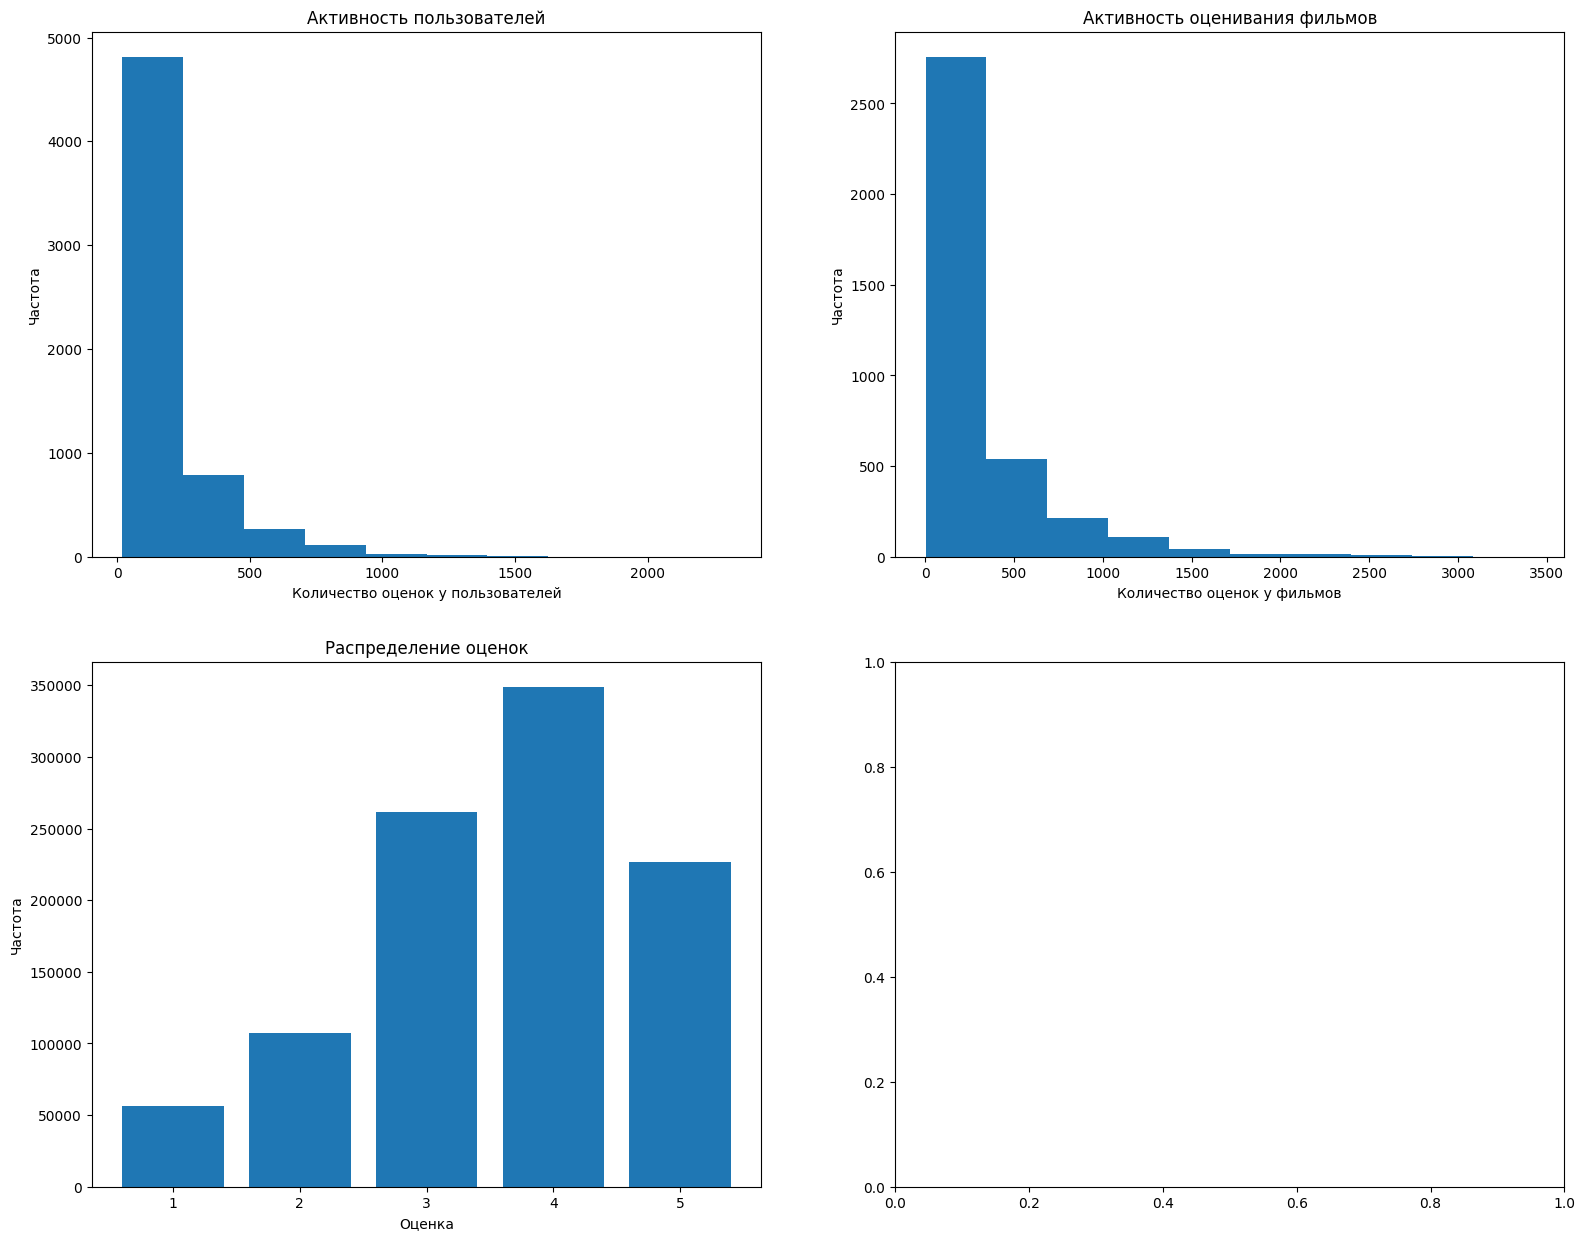

In [29]:
fig, axs = plt.subplots(2,2, figsize=(19,15))

ax = axs[0, 0]
ax.hist(reviews.groupby('user_id').count()['item_id'])
ax.set_title('Активность пользователей')
ax.set_xlabel('Количество оценок у пользователей')
ax.set_ylabel('Частота')

ax = axs[0, 1]
ax.hist(reviews.groupby('item_id').count()['user_id'])
ax.set_title('Активность оценивания фильмов')
ax.set_xlabel('Количество оценок у фильмов')
ax.set_ylabel('Частота')

ax = axs[1, 0]
ax.bar([1,2,3,4,5], reviews.groupby('relevance').count()['user_id'])
ax.set_title('Распределение оценок')
ax.set_xlabel('Оценка')
ax.set_ylabel('Частота')

ax = axs[1, 0]
ax.bar([1,2,3,4,5], reviews.groupby('relevance').count()['user_id'])
ax.set_title('Распределение оценок')
ax.set_xlabel('Оценка')
ax.set_ylabel('Частота')

## Задание 2
**(0.5 балла) Задание 2.**
Фильтрация и разбиение данных

Будем использовать global time split, т.е. отделим train и validation по выбранной дате.

Реализуйте такое разбиение:

1) данные до 1 декабря 2000 года не включая - данные train

2) данные с 1 декабря 2000 года включительно до 31 декабря 2000 года включительно - валидационные данные.

В валидационных данных должны остаться только положительные оценки (хотим предсказать, что пользователю понравится). Будем считать положительными оценки > 3. Удалим из валидационной выборки холодных пользователей, так как большинство рассматриваемых алгоритмов не генерируют рекомендации для холодных.

In [ ]:
# YOUR CODE HERE
# train =
# val =

In [ ]:
assert train.shape[0] == 791270
assert val.shape[0] == 14790

In [ ]:
get_log_info(train)

Длина лога = 791270,
количество пользователей = 5365,
количество объектов = 3662


In [ ]:
get_log_info(val)

Длина лога = 14790,
количество пользователей = 522,
количество объектов = 2341


## Задание 3
**(0.5 балла) Задание 3.** Базовое решение.

Порекомендуем для каждого пользователя из val 20 случайных фильмов. Датасет с рекомендациями должен содержать колонки  user_id, item_id, relevance.

In [ ]:
%%time
# YOUR CODE HERE
# random_pred =

CPU times: user 53.7 ms, sys: 5.4 ms, total: 59.1 ms
Wall time: 70.4 ms


In [ ]:
assert random_pred.shape[0] == val['user_id'].nunique() * K

In [ ]:
random_pred.head(1)

,user_id,item_id,relevance
100406,670,1750,1.0


## Задание 4
**(1.25 балл) Задание 4.** Метрики качества.


Используйте следующий набор метрик качества:
- NDCG@K (необходимо реализовать) **(0.5 балла)**
- HitRate@K (можно взять с семинара или использовать готовую реализацию)
- Coverage@K (можно взять с семинара или использовать готовую реализацию)
- Surprisal@K (необходимо реализовать) **(0.5 балла)**

1) Реализуйте метрики NDCG@K, Surprisal@K **(1 балл)**

2) **(0.25 балла)** Создайте функцию, которая генерирует словарь/dataframe с 4 метриками по предоставленному решению. Оцените baseline-решение на валидации


Не забудьте, что мы можем считать метрику для разных значений k (например, изначально подготовили 10 рекомендаций, а считаем метрику для k = 1, 5, 10). В этом случае при подсчете метрики используются первые top-k рекомендаций и все релевантные айтемы из ground truth.

Будем использовать следующие обозначения в формулах:

$i$ – идентификатор пользователя, целое число от 1 до N

$j$ – позиция товара в списке рекомендаций для пользователя $i$, целое число от 1 до K

$N$ – количество пользователей

$K$ – количество айтемов в списке рекомендаций, для которого рассчитывается метрика

$\mathbb{1}_{r_{ij}}$ - индикаторная функция, факт приобретения пользователем i продукта на позиции j  в списке рекомендаций

$|Rel_i|$ - количество айтемов, с которыми были положительные взаимодействия у пользователя $i$ в тестовом периоде


### NDCG

Реализуйте бинарную версию метрики NDCG (Normalized Discounted Cumulative Gain) для оценки качества ранжирования. В банирной версии фактические значения релевантности в ground truth игнорируются, используется только инофрация о факте положительного взаимодействия.

1) Посчитаем DCG

$$DCG@K(i) = \sum_{j=1}^{K}\frac{\mathbb{1}_{r_{ij}}}{\log_2 (j+1)}$$

2) Чтобы получить Normalized метрику, вычислим максимально возможное для данного пользователя значение $DCG@K$, $IDCG@K$.

$$IDCG@K(i) = max(DCG@K(i)) = \sum_{j=1}^{K}\frac{\mathbb{1}_{j\le|Rel_i|}}{\log_2 (j+1)}$$

$$nDCG@K(i) = \frac{DCG@K(i)}{IDCG@K(i)}$$

3) Результат усредним по пользователям.

$$ nDCG@K = \frac{\sum_{i=1}^{N}nDCG@K(i)}{N}$$
    


#### NDCG для одного пользователя

In [ ]:
import math

In [ ]:
def ndcg_user(row, k):
    """
    row: row of pd.Dataframe with columns `pred_list`, `gt_list`
    """
    # YOUR CODE HERE
    pass

In [ ]:
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [1, 2, 3], 'gt_list': [4, 5, 2, 6]}), k=3), 0.296, abs_tol=1e-3)
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [1, 2, 3], 'gt_list': [4, 5, 2, 6]}), k=5), 0.246, abs_tol=1e-3)
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [1, 2, 3], 'gt_list': [4, 5, 2, 6]}), k=1), 0., abs_tol=1e-3)
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [], 'gt_list': [4, 5, 2, 6]}), k=10), 0)
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [1, 3], 'gt_list': []}), k=10), 0)

In [ ]:
# YOUR CODE HERE: оценка NDCG для всех пользователей. На вход приходят рекомендации в формате как в задании 3

### Surprisal
Посмотрим, насколько наши рекомендации хороши с точки зрения новизны для пользователя. В качестве новизны будем рассматривать "непопулярность" айтемов в рекомендациях.

1. Будем рассматривать собственную информацию item-а как меру его новизны для пользователей.

    $$selfInformation(i) = -\log_2 \frac{|u_i|}{N}, $$
    где $i$ - объект (item), $N$ - число пользователей в обучающей выборке, $|u_i|$ - число пользователей, взаимодействовавших с объектом $i$ в обучающей выборке.


2. Собственная информация определяется для item-а, а значение метрики мы хотим считать для пользователя и $k$ - количества рекомендаций. Для подсчета Surprisal пользователя усредним значения собственной информации в топ-k рекомендациях этого пользователя.

    Чтобы получить значения от 0 до 1, разделим значение метрики для пользователя на максимально возможно значение метрики равное $log_2 N$.

$$Surprisal(u, k) = \frac{1}{k log_2 N} \sum_{i}^{k}selfInformation(i)$$


3. Результат усредним по пользователям.

Что делать с холодными item-ами при подсчете $selfInformation$? Максимально простой вариант — считать, что для них было взаимодействие с одним пользователем.

Обратите внимание, что self information можно расчитать один раз при инициализации метрики. Возможно, эту метрику стоит сделать классом.

In [ ]:
class Surprisal:
    def __init__(self, log: pd.DataFrame):
        # YOUR CODE HERE
        pass

    def __call__(self, pred, k):
        # YOUR CODE HERE
        pass

In [ ]:
surp = Surprisal(pd.DataFrame({'user_id': [1, 2, 3, 3], 'item_id': [1, 2, 2, 3], 'relevance': [0.5, 0.1, 1., 0.1]}))
assert math.isclose(surp(pd.DataFrame({'user_id': [1], 'item_id': [4], 'relevance': [0.5]}), k=1), 1)
assert math.isclose(surp(pd.DataFrame({'user_id': [1], 'item_id': [4], 'relevance': [0.5]}), k=2), 0.5)
assert math.isclose(surp(pd.DataFrame({'user_id': [2, 2], 'item_id': [3, 2], 'relevance': [0.1, 1]}), k=2), 0.685, abs_tol=1e-3)
assert math.isclose(surp(pd.DataFrame({'user_id': [1, 2, 2], 'item_id': [4, 3, 2], 'relevance': [0.5, 0.1, 1]}), k=2), (0.684 + 0.5) / 2, abs_tol=1e-3)

In [ ]:
# YOUR CODE HERE: оценка 4 метрик для рекомендаций из задания 3

## Задание 5
**(1.25 балла) Задание 5.** item-based knn

1) **(0.5 балла)** Примените [CosineRecommender](https://benfred.github.io/implicit/api/models/cpu/knn.html) из библиотеки [implicit](https://github.com/benfred/implicit). Оцените влияние количества соседей (параметр K) на качество рекомендаций (по 4 реализованным метрикам). Постройте график зависимости NDCG@20 от числа соседей.

2) **(0.5 балла)** Разберитесь, в чем состоит идея использования весов tfidf и bm25, например, по [этой статье](https://www.benfrederickson.com/distance-metrics/). Выберите один из способов (tfidf или bm25) взвешивания, опишите текстом основную идею. Примените выбранную модель, подберите гиперпараметры на отложенных данных (разбейте самостоятельно) и оцените качество на val-датасете.

3) **(0.25 балла)** Повторите эксперимент, используя для обучения только положительные оценки (> 3). Не забудьте при фильтрации просмотренных учесть все взаимодействия (не только положительные). Как это повлияло на качество?

Удалось ли достичь лучшего качества, чем с использованием Cosine?

In [ ]:
! pip install implicit

## Задание 6. ALS (1.0 балл)

1) **(0.5 балла)** Примените ALS из библиотеки [implicit](https://github.com/benfred/implicit), используя для обучения все оценки. Оцените зависимость качества рекомендаций (по 4 реализованным метрикам) от количества факторов (параметр factors). Постройте график зависимости NDCG@20 от числа соседей.

2) **(0.5 балла)** Повторите эксперимент из пункта 1, используя для обучения только положительные оценки (> 3). Не забудьте при фильтрации просмотренных учесть все взаимодействия (не только положительные). Как это повлияло на качество?

Обратитие внимание на наличие регуляризации в параметрах модели. Для достижения хорошего качества модели необходимо подбирать количество факторов и степень регуляризации одновременно на отложенной выборке, например, с использованием [optuna](https://optuna.org/).

# Подготовьте выводы по всему ноутбуку
Какие модели работали лучше? Какие для этого могут быть причины? Какие из моделей наиболее чувствительны к настройке гиперпараметров? Расскажите об интересных наблюдениях и трудностях.